In [1]:
import numpy as np
from extraction_tools import SpectralExtraction, combine_extractions

filters = {'g235h': 'f170lp', 'g395h': 'f290lp', 'g140h': 'f100lp'}

2025-07-31 16:19:30,121 - stpipe - WARNING - /net/schenk/data2/regt/JWST_reductions/jwst_nirspec_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,

2025-07-31 16:19:30,337 - stpipe - WARNING - /net/schenk/data2/regt/JWST_reductions/extraction_tools.py:170: RuntimeWarning: All-NaN slice encountered
  horizontal_collapsed = np.nanmedian(masked_cube, axis=2, keepdims=True)



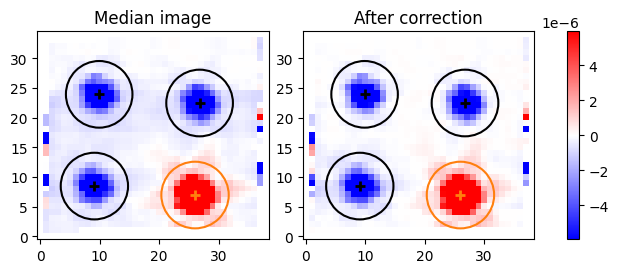

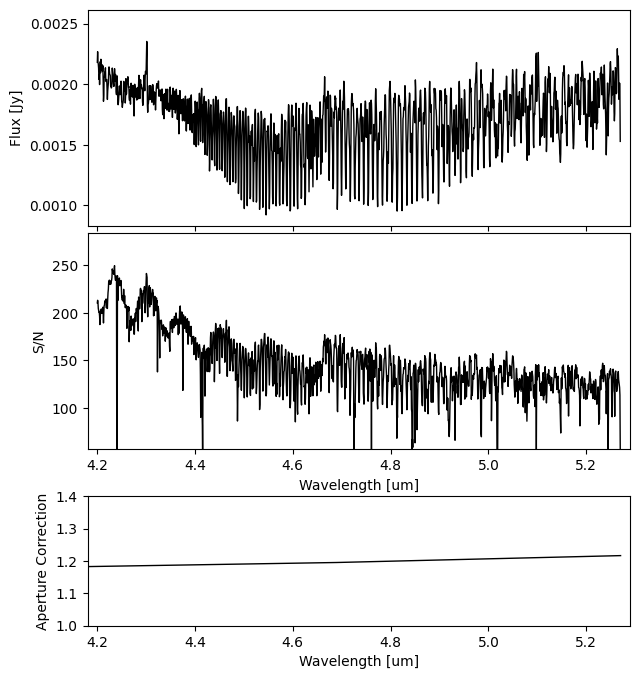

2025-07-31 16:19:32,152 - stpipe - WARNING - /net/schenk/data2/regt/JWST_reductions/jwst_nirspec_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,

2025-07-31 16:19:32,364 - stpipe - WARNING - /net/schenk/data2/regt/JWST_reductions/extraction_tools.py:170: RuntimeWarning: All-NaN slice encountered
  horizontal_collapsed = np.nanmedian(masked_cube, axis=2, keepdims=True)



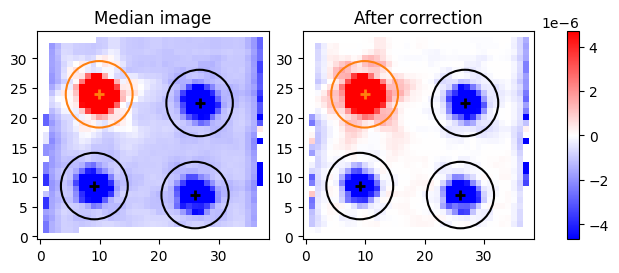

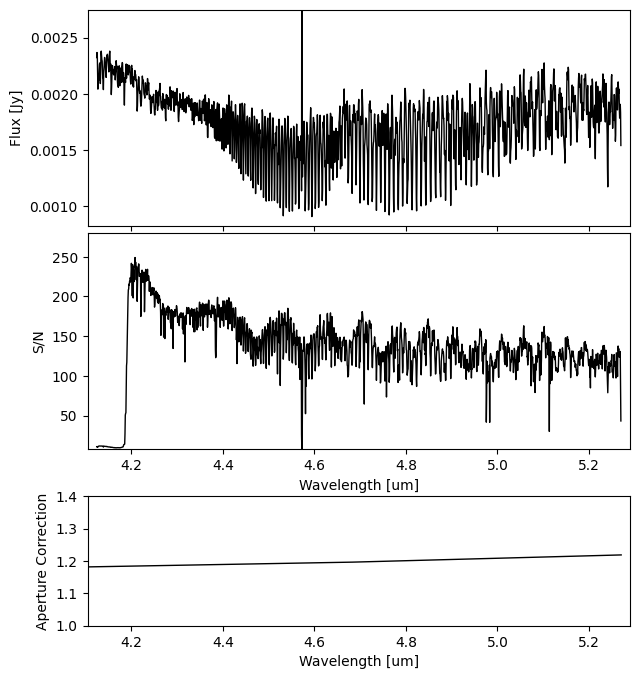

2025-07-31 16:19:34,251 - stpipe - WARNING - /net/schenk/data2/regt/JWST_reductions/jwst_nirspec_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,

2025-07-31 16:19:34,509 - stpipe - WARNING - /net/schenk/data2/regt/JWST_reductions/extraction_tools.py:170: RuntimeWarning: All-NaN slice encountered
  horizontal_collapsed = np.nanmedian(masked_cube, axis=2, keepdims=True)



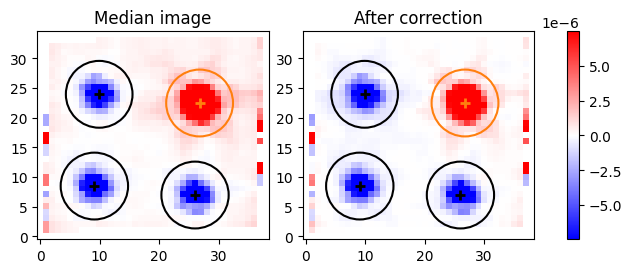

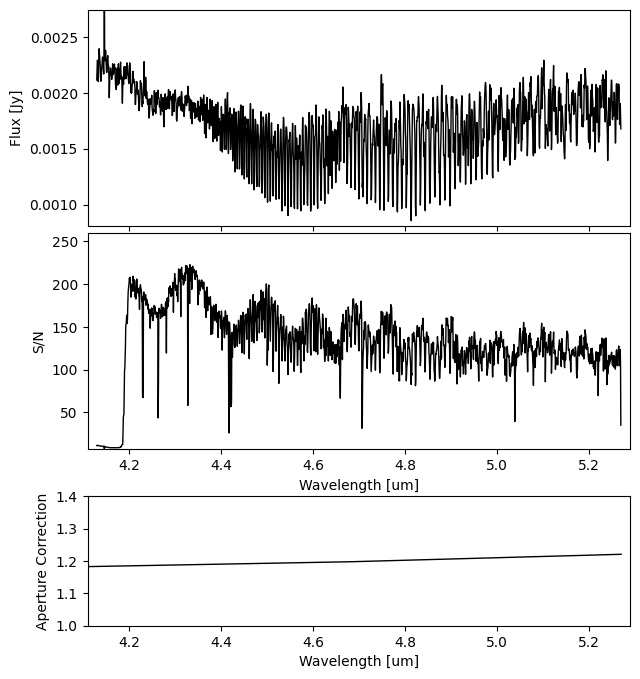

2025-07-31 16:19:36,436 - stpipe - WARNING - /net/schenk/data2/regt/JWST_reductions/jwst_nirspec_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,

2025-07-31 16:19:36,711 - stpipe - WARNING - /net/schenk/data2/regt/JWST_reductions/extraction_tools.py:170: RuntimeWarning: All-NaN slice encountered
  horizontal_collapsed = np.nanmedian(masked_cube, axis=2, keepdims=True)



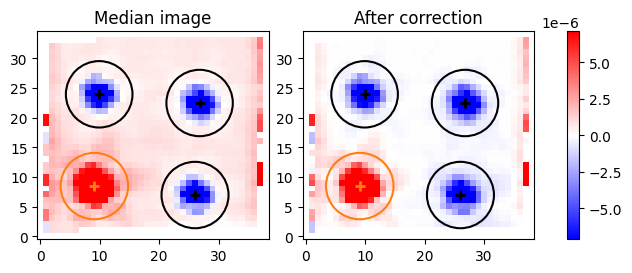

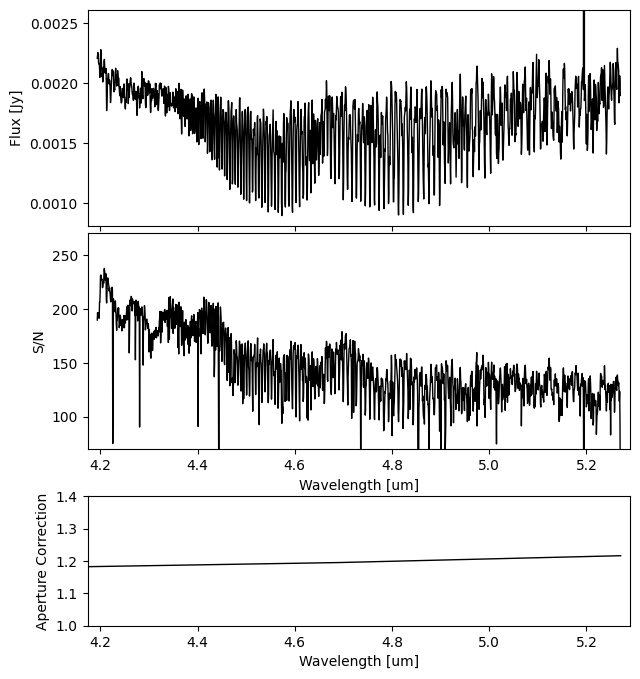

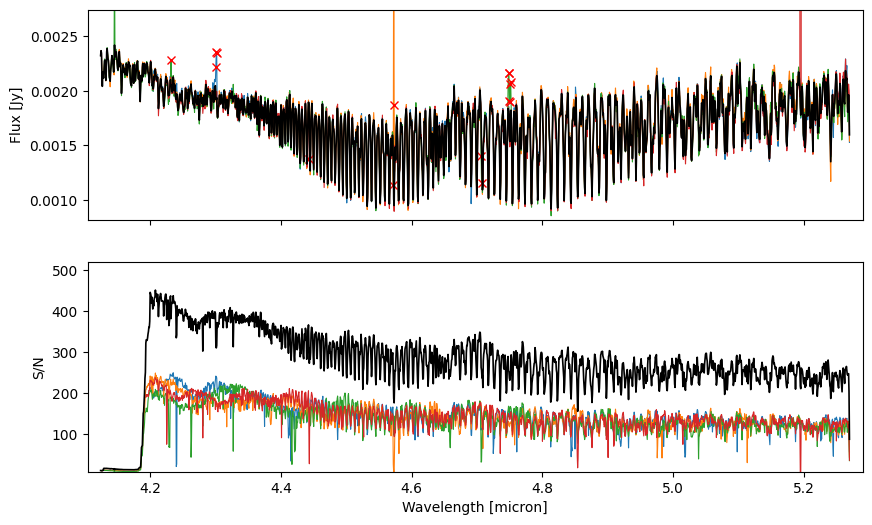

In [21]:
filename = './NIRSPEC_ifu_data_01386/stage2/jw01386013001_{0}_{1:05d}_{2}_{3}.fits'
grating = 'g395h'
detector = 'nrs2'

SEs = []
AC = None # No aperture correction has been calculated yet
for dither in [1,2,3,4]:
    if grating == 'g140h':
        file_s3d = filename.format('03106', dither, detector, 's3d')
        file_x1d = filename.format('03106', dither, detector, 'x1d')
    elif grating == 'g235h':
        file_s3d = filename.format('03102', dither, detector, 's3d')
        file_x1d = filename.format('03102', dither, detector, 'x1d')
    elif grating == 'g395h':
        file_s3d = filename.format('03104', dither, detector, 's3d')
        file_x1d = filename.format('03104', dither, detector, 'x1d')

    SE = SpectralExtraction(
        file_s3d=file_s3d, file_wave=file_x1d, 
        disperser=grating.upper(), filter=filters[grating], AC=AC,
    )
    SE.correct_horizontal_stripes((9, 8), (26, 7), (10, 24), (27, 23), radius_inflation=6)
    SE.extract_1d(radius_inflation=4)

    SEs.append(SE); AC = SE.AC # Re-use the aperture correction

# Combine dithers
combine_extractions(*SEs, sigma_clip=20, plot=True)#, xlim=(2.18, 2.23))

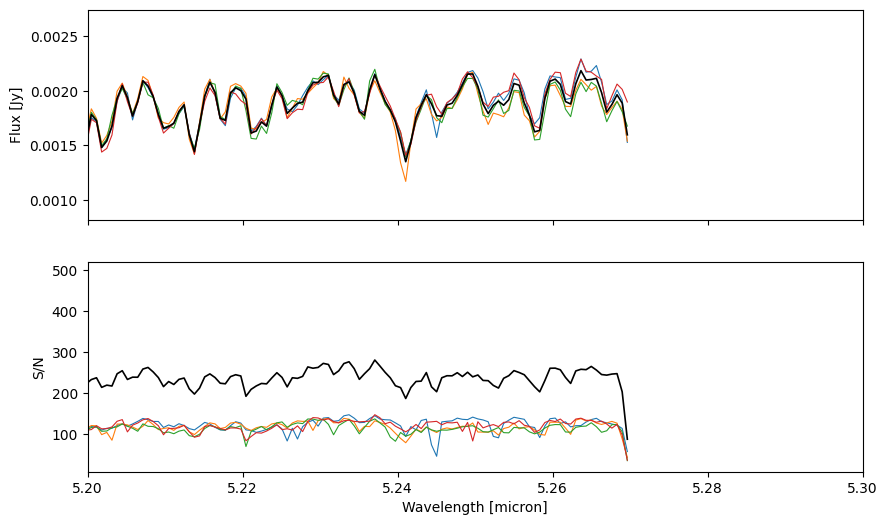

In [27]:
combine_extractions(*SEs, sigma_clip=20, plot=True, xlim=(5.2,5.3))